In [17]:
library(tidyverse)
library(ggplot2)
library(caret)
library(glmnet)
library(ranger)
library(e1071)

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 2.2.1     v purrr   0.2.4
v tibble  1.3.4     v dplyr   0.7.4
v tidyr   0.8.0     v stringr 1.2.0
v readr   1.1.1     v forcats 0.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift

Warning message:
"package 'glmnet' was built under R version 3.4.4"Loading required package: Matrix

Attaching package: 'Matrix'

The following object is masked from 'package:tidyr':

    expand

Loading required package: foreach

Attaching package: 'foreach'

The following objects are masked from 'package:purrr':

    accumulate, when

Loaded glmnet 2.0-16

Warning message:
"package 'ranger' was built under R version 3.4.4"Warning message:
"package 'e1071' was built under R version 3.

In [18]:
setwd('C:/Users/Kevin/Desktop/Kaggle/Titanic')

train <- read.csv('Train.csv')
test <- read.csv('Test.csv')

train$train <- 1
test$train <- 0

str(train$Survived)
test$Survived <- 1

titanic <- rbind(train,test)

 int [1:891] 0 1 1 1 0 0 0 0 1 1 ...


In [19]:
#Looking at data types and changing to correct class
str(titanic)

titanic$Name <- as.character(titanic$Name)
titanic$Survived <- as.factor(titanic$Survived)
titanic$Pclass <- as.factor(titanic$Pclass)

'data.frame':	1309 obs. of  13 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : num  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : Factor w/ 1307 levels "Abbing, Mr. Anthony",..: 109 191 358 277 16 559 520 629 417 581 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : Factor w/ 929 levels "110152","110413",..: 524 597 670 50 473 276 86 396 345 133 ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : Factor w/ 187 levels "","A10","A14",..: 1 83 1 57 1 1 131 1 1 1 ...
 $ Embarked   : Factor w/ 4 levels "","C","Q","S": 4 2 4 4 4 3 4 4 4 2 ...
 $ train      : num  1 1 1 1 1 1 1 1 1 1 ...


In [20]:
#Now I will look at each feature to see if there are any data errors
#Survived
table(titanic$Survived)

#looks fine


  0   1 
549 760 

In [21]:
#Class
table(titanic$Pclass)
#Okay


  1   2   3 
323 277 709 

In [22]:
#Sex
table(titanic[,5])
#Okay


female   male 
   466    843 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 263 rows containing non-finite values (stat_bin)."

[1] 0.17

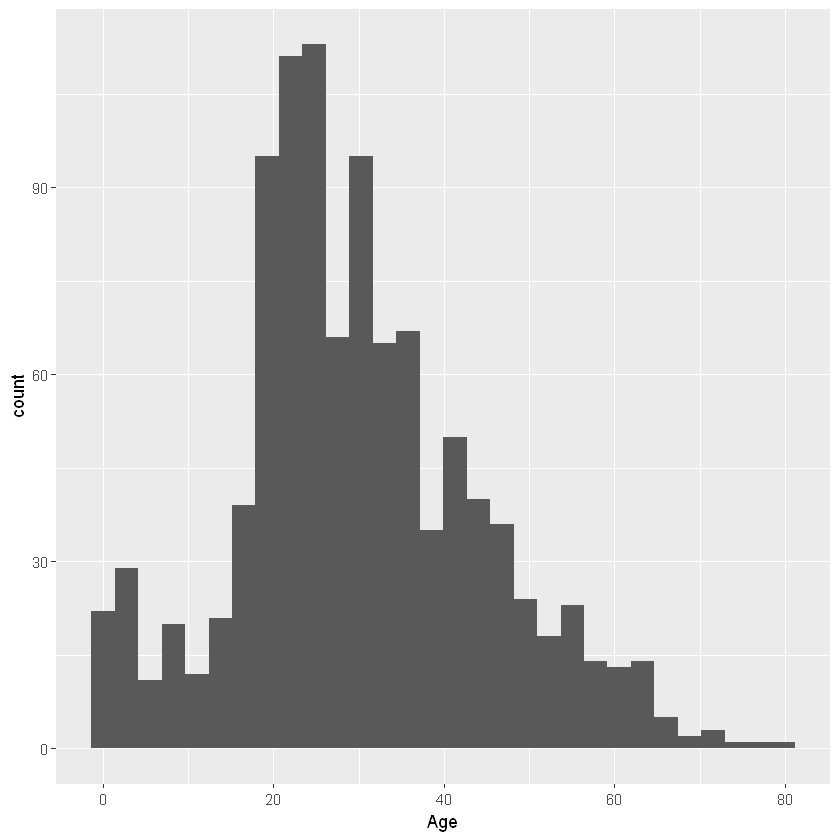

In [23]:
#Age
#263 NAs.
ggplot(titanic,aes(Age)) + geom_histogram()
#Min and max values are okay
min(titanic$Age, na.rm = TRUE)

In [24]:
#Siblings/Spouses on Board - most are 0's does this make sense? 
#(cruises are a family thing but it could have been different back then)
table(titanic$SibSp)


  0   1   2   3   4   5   8 
891 319  42  20  22   6   9 

In [25]:
#Number of children/parents on board - most are 0 again
table(titanic$Parch)


   0    1    2    3    4    5    6    9 
1002  170  113    8    6    6    2    2 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 1 rows containing non-finite values (stat_bin)."

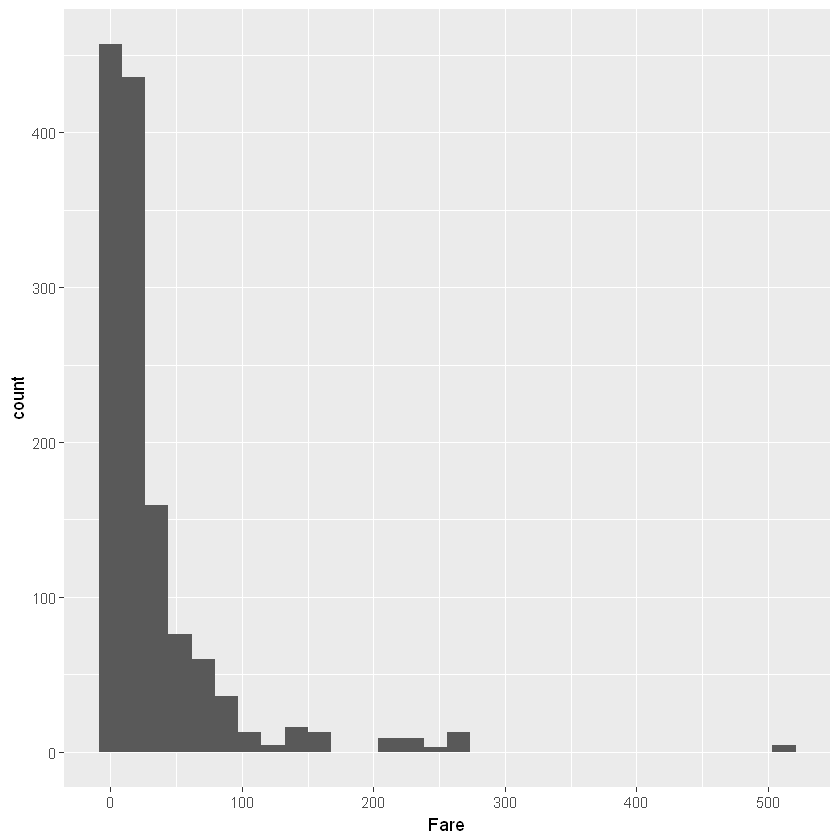

In [26]:
#17 0's and 1 NA - I'm going to assume the 0's are accurate
#Also the max ticket price is fair, google says tickets went up
#to $2500
#I will impute the NA later on
ggplot(titanic,aes(Fare)) + geom_histogram()

In [27]:
#Cabin variable is extremely messy. 
#over 1000 are blank and there are many duplicate entries
table(titanic$Cabin)


                            A10             A14             A16             A19 
           1014               1               1               1               1 
            A20             A23             A24             A26             A31 
              1               1               1               1               1 
            A32             A34             A36              A5              A6 
              1               3               1               1               1 
             A7            B101            B102             B18             B19 
              1               1               1               2               1 
            B20             B22             B28              B3             B30 
              2               2               2               1               1 
            B35             B37             B38             B39              B4 
              2               1               1               1               1 
            B41            

In [28]:
#To Impute Age I will look at the title of the 
#person and use the median of each title as their age

AgeNA <- titanic %>% filter(is.na(Age))

AgeNA_MR <- grep(', Mr.', AgeNA$Name, value = TRUE, fixed = TRUE)
AgeNA_MRS <- grep(', Mrs.', AgeNA$Name, value = TRUE, fixed = TRUE)
AgeNA_Miss <- grep(', Miss.', AgeNA$Name, value = TRUE, fixed =TRUE)
AgeNA_Master<-grep(', Master.', AgeNA$Name,value =TRUE,fixed = TRUE)

#all but 2 of the Age NAs have these titles 

LastNA <- AgeNA[!(AgeNA$Name %in% AgeNA_MR) & 
                  !(AgeNA$Name %in% AgeNA_MRS) & 
                  !(AgeNA$Name %in% AgeNA_Miss) & 
                  !(AgeNA$Name %in% AgeNA_Master),]


#Last two - one is a Dr. and one is a Ms.
#I will make a seperate Dr. column and include Ms. in Miss.
Ms <- LastNA %>% filter(!(Pclass == 1))
LastNA <- LastNA %>% filter(Pclass == 1)

In [29]:
#Computing the median age of Mr, Miss, Master, and Dr titles.
Age_MR <- titanic[grep(', Mr.', titanic$Name, fixed = TRUE),]
median_Age_MR <- median(as.numeric(Age_MR$Age), na.rm = TRUE)

Age_Miss <- titanic[grep(', Miss.', titanic$Name, fixed = TRUE),]
median_Age_Miss <- median(as.numeric(Age_Miss$Age), na.rm = TRUE)

Age_Mrs <- titanic[grep(', Mrs.', titanic$Name, fixed = TRUE),]
median_Age_Mrs <- median(as.numeric(Age_Mrs$Age), na.rm = TRUE)

Age_Master <-titanic[grep(', Master.', titanic$Name, fixed = TRUE),]
median_Age_Master<- median(as.numeric(Age_Master$Age), na.rm = TRUE)

Age_Dr <- titanic[grep(', Dr.', titanic$Name, fixed = TRUE),]
median_Age_Dr <- median(as.numeric(Age_Dr$Age), na.rm = TRUE)

#Results seem to make sense - Dr is oldest, Married women 2nd, 
#married or unmarried men 3rd, unmarried women/girls 4th, 
#and boys 5th.
c(median_Age_MR , median_Age_Miss , median_Age_Mrs , 
  median_Age_Master ,median_Age_Dr)

#Inputting new values for age
titanic$Age <- ifelse(titanic$Name %in% AgeNA_MR,29, titanic$Age)
titanic$Age <- ifelse(titanic$Name %in% AgeNA_Miss,22, titanic$Age)
titanic$Age <- ifelse(titanic$Name %in% AgeNA_MRS,35.5, titanic$Age)
titanic$Age <- ifelse(titanic$Name %in% AgeNA_Master,4, titanic$Age)
titanic$Age <- ifelse(titanic$Name %in% LastNA$Name,49, titanic$Age)

titanic$Age <- ifelse(titanic$Name %in% Ms, 22, titanic$Age)

#no more na values for Age
sum(!is.na(titanic$Age))

[1] 29.0 22.0 35.5  4.0 49.0

[1] 1309

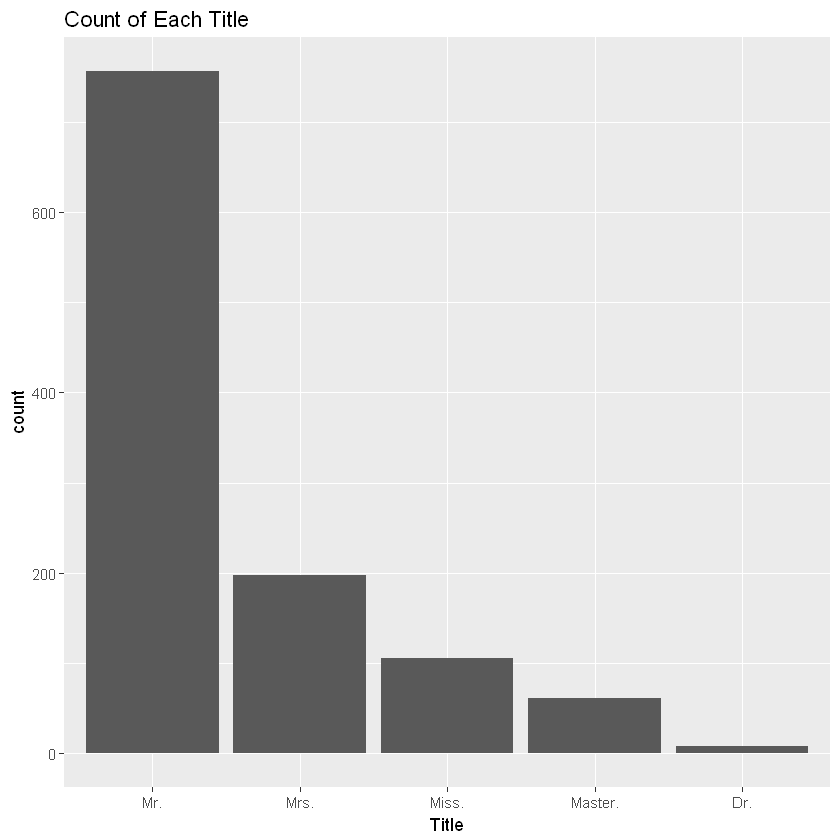

In [30]:
#Checking to see the count of titles

Titles <- data.frame(Title = rep('Mr.', 757))
Titles <- rbind(Titles, data.frame(Title = rep('Mrs.', 197)) )
Titles <- rbind(Titles, data.frame(Title = rep('Miss.', 105)) )
Titles <- rbind(Titles, data.frame(Title = rep('Master.', 61)) )
Titles <- rbind(Titles, data.frame(Title = rep('Dr.', 8)) )

ggplot(Titles) + geom_bar(aes(as.factor(Title))) + 
  xlab('Title') +
  ggtitle('Count of Each Title')

#The number of singles far outweighs the number of 
#couples/families so the SibSp and Parch being most 0's is fine
#(These 5 titles contain 1128 out of the 1319 people)

In [31]:
#NA Fare is a third class male from the test set. 
#I will impute his fare from 3rd class men.
NAfare <- titanic %>% filter(is.na(Fare))
NAfare



PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train
1044,1,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NA,,S,0


In [32]:
MrThirdClass<-titanic[grep(', Mr.',titanic$Name, fixed = TRUE),]%>% 
                filter(Pclass == 3)

MrThirdClass_Median_Fare <- median(MrThirdClass$Fare, na.rm = TRUE)


titanic$Fare <- ifelse(titanic$Name %in% NAfare, 7.8958, 
                       titanic$Fare)

#No more Fare NA's
sum(!is.na(titanic$Fare))


[1] 1309

In [33]:
set.seed(1234)

#Splitting dataset back into train and test
train_final <- titanic %>% filter(train == 1)
test_final <- titanic %>% filter(train == 0)

#Using 5 fold cross validation
control_parm <- trainControl(method = 'cv',
                            number = 5,
                            verboseIter = TRUE,
                            savePredictions = TRUE)

#Using random Forest because of lax assumptions
RFmodel <- train(Survived ~ Pclass + Sex + Age + SibSp + 
                     Fare + Parch + Embarked ,
                     data=train_final,
                     method='rf',
                     preProcess = c("center","scale"),
                     trControl = control_parm,
                     tuneGrid = data.frame(mtry = 
                        c(2,2, 3,3,4,4,5,5,6, 6,7, 7,8,8,9,9)),
                     importance = TRUE
)




+ Fold1: mtry=2 
- Fold1: mtry=2 
+ Fold1: mtry=2 
- Fold1: mtry=2 
+ Fold1: mtry=3 
- Fold1: mtry=3 
+ Fold1: mtry=3 
- Fold1: mtry=3 
+ Fold1: mtry=4 
- Fold1: mtry=4 
+ Fold1: mtry=4 
- Fold1: mtry=4 
+ Fold1: mtry=5 
- Fold1: mtry=5 
+ Fold1: mtry=5 
- Fold1: mtry=5 
+ Fold1: mtry=6 
- Fold1: mtry=6 
+ Fold1: mtry=6 
- Fold1: mtry=6 
+ Fold1: mtry=7 
- Fold1: mtry=7 
+ Fold1: mtry=7 
- Fold1: mtry=7 
+ Fold1: mtry=8 
- Fold1: mtry=8 
+ Fold1: mtry=8 
- Fold1: mtry=8 
+ Fold1: mtry=9 
- Fold1: mtry=9 
+ Fold1: mtry=9 
- Fold1: mtry=9 
+ Fold2: mtry=2 
- Fold2: mtry=2 
+ Fold2: mtry=2 
- Fold2: mtry=2 
+ Fold2: mtry=3 
- Fold2: mtry=3 
+ Fold2: mtry=3 
- Fold2: mtry=3 
+ Fold2: mtry=4 
- Fold2: mtry=4 
+ Fold2: mtry=4 
- Fold2: mtry=4 
+ Fold2: mtry=5 
- Fold2: mtry=5 
+ Fold2: mtry=5 
- Fold2: mtry=5 
+ Fold2: mtry=6 
- Fold2: mtry=6 
+ Fold2: mtry=6 
- Fold2: mtry=6 
+ Fold2: mtry=7 
- Fold2: mtry=7 
+ Fold2: mtry=7 
- Fold2: mtry=7 
+ Fold2: mtry=8 
- Fold2: mtry=8 
+ Fold2: mtry=

Random Forest 

891 samples
  7 predictor
  2 classes: '0', '1' 

Pre-processing: centered (10), scaled (10) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 714, 713, 713, 712, 712 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
  2     0.8193219  0.6002822
  3     0.8294061  0.6273833
  4     0.8321867  0.6361270
  5     0.8305233  0.6336908
  6     0.8249115  0.6223268
  7     0.8204359  0.6147759
  8     0.8164907  0.6066433
  9     0.8147863  0.6033825

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 4.


Call:
 randomForest(x = x, y = y, mtry = param$mtry, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 16.61%
Confusion matrix:
    0   1 class.error
0 498  51  0.09289617
1  97 245  0.28362573

rf variable importance

          Importance
Sexmale     100.0000
Age          32.1587
Pclass3      28.5092
Fare         27.1347
SibSp        10.1277
Parch         5.4450
Pclass2       4.8902
EmbarkedS     4.0873
EmbarkedQ     0.7913
EmbarkedC     0.0000

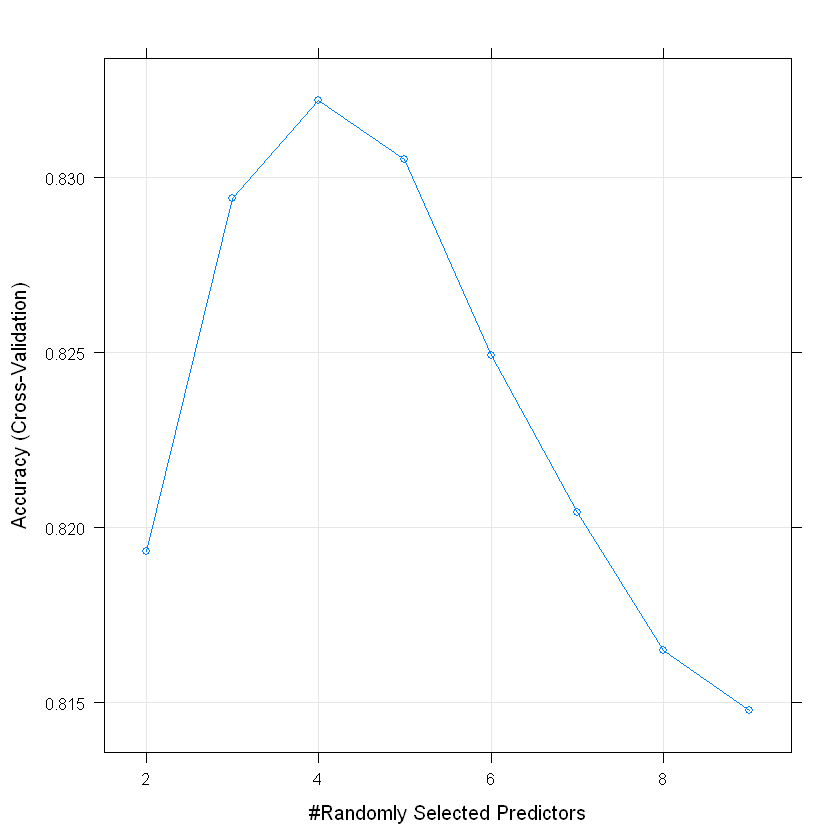

In [35]:

RFmodel
plot(RFmodel)
RFmodel$finalModel


#Variable importance
varImp(RFmodel)

In [36]:
#Prediction and writing the final csv
RFprediction <- predict(RFmodel, newdata=test_final )
table(RFprediction)

final_prediction <- data.frame(PassengerId = c(892:1309) , 
                               Survived = RFprediction)


write.csv(final_prediction, 
    'C:/Users/Kevin/Desktop/Kaggle/Titanic/Final_Submission.csv', 
    row.names = TRUE)

RFprediction
  0   1 
273 145 